# Homework 4 - Recommendation systems and clustering everywhere
---

## IMPORTING LIBRARIES 

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from tqdm import tqdm
import nltk
from nltk.stem import WordNetLemmatizer
import string
import pickle

### Exploratory Data Analysis

Let us start off by importing our dataset and taking a look at it to understand the data.

In [4]:
netflix = pd.read_csv(r"Data\vodclickstream_uk_movies_03.csv")                                          

print(len(netflix["title"].unique()), len(netflix["movie_id"].unique()))            # These two columns are not equal in length, ~500 items have
                                                                                    # the same title but are different  
netflix = netflix.sort_values(["user_id", "movie_id", "datetime"])
netflix.head(20)                                                                    # Some movies also have the same user clicking on the same move
                                                                                    # on the exact same datetime, with one being 0 seconds and the 
                                                                                    # other being more than 0, this will be counted as one


7925 8472


,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
223802,282575,2017-12-05 20:39:15,0.0,Hannibal,"Crime, Drama, Thriller",2001-02-09,9bfee795ff,00004e2862
89781,148554,2017-05-30 20:36:34,0.0,Green Room,"Horror, Music, Thriller",2016-05-13,43bb6de314,000052a0a0
102939,161712,2017-06-18 20:38:02,0.0,Looper,"Action, Drama, Sci-Fi, Thriller",2012-09-28,4718f9963c,000052a0a0
102994,161767,2017-06-18 20:44:27,0.0,Looper,"Action, Drama, Sci-Fi, Thriller",2012-09-28,4718f9963c,000052a0a0
103016,161789,2017-06-18 20:44:27,0.0,Looper,"Action, Drama, Sci-Fi, Thriller",2012-09-28,4718f9963c,000052a0a0
103035,161808,2017-06-18 20:44:27,0.0,Looper,"Action, Drama, Sci-Fi, Thriller",2012-09-28,4718f9963c,000052a0a0
103059,161832,2017-06-18 20:44:27,0.0,Looper,"Action, Drama, Sci-Fi, Thriller",2012-09-28,4718f9963c,000052a0a0
103082,161855,2017-06-18 20:44:27,0.0,Looper,"Action, Drama, Sci-Fi, Thriller",2012-09-28,4718f9963c,000052a0a0
103110,161883,2017-06-18 20:44:27,600.0,Looper,"Action, Drama, Sci-Fi, Thriller",2012-09-28,4718f9963c,000052a0a0
103145,161918,2017-06-18 20:44:27,0.0,Looper,"Action, Drama, Sci-Fi, Thriller",2012-09-28,4718f9963c,000052a0a0


## [1] Recommendation sytem
---
We will attempt to implement a recommendation system by identifying similar users' preferences and recommending movies they watch to the study user.


### [1.1] Top 10 Movies per User
Lets work on creating a dataframe of sorted user IDs, and their favorite movies from 1st to 10th, based on number of clicks, two clicks on the same exact datetime will be counted as one. Ties will be split by duration.

In [5]:
import pandas as pd

netflix = pd.read_csv(r"Data\vodclickstream_uk_movies_03.csv").sort_values(["user_id", "movie_id", "datetime", "duration"])

# Drop duplicates when we have the same user clicking on the same movie at the same exact time
netflix = netflix.drop_duplicates(subset=['user_id', 'movie_id', 'datetime'])

# Aggregate data sorting by users, then by movies
# Take the first title, the size of datetime as number of clicks, the first genre, and the total duration
aggregated_data = netflix.groupby(["user_id", "movie_id"]).agg({ "title": "first", "datetime": "size",  "genres": "first","duration": "sum"})
aggregated_data = aggregated_data.reset_index().rename(columns={"datetime": "click_count"})

# Sort the data and get top 10  or less movies per user
top_movies_per_user = aggregated_data.sort_values(by=["user_id", "click_count", "duration"], ascending=[True, False, False]).groupby("user_id").head(10)

top_movies_per_user.head(25)


,user_id,movie_id,title,click_count,genres,duration
0,00004e2862,9bfee795ff,Hannibal,1,"Crime, Drama, Thriller",0.0
2,000052a0a0,4718f9963c,Looper,3,"Action, Drama, Sci-Fi, Thriller",6736.0
6,000052a0a0,7314699c23,Frailty,3,"Crime, Drama, Thriller",5667.0
3,000052a0a0,4fa0b092d6,Jumanji,3,"Adventure, Comedy, Family, Fantasy",4387.0
5,000052a0a0,6275614f9a,Resident Evil,2,"Action, Horror, Sci-Fi",4279.0
8,000052a0a0,cccedbafeb,Resident Evil: Retribution,1,"Action, Horror, Sci-Fi, Thriller",7857.0
10,000052a0a0,f254d41c3d,The Nice Guys,1,"Action, Comedy, Crime, Mystery, Thriller",7025.0
4,000052a0a0,59d313ed8b,Ant-Man,1,"Action, Adventure, Comedy, Sci-Fi",6226.0
7,000052a0a0,96debad268,The SpongeBob Movie: Sponge Out of Water,1,"Animation, Action, Adventure, Comedy, Family, ...",4547.0
9,000052a0a0,d601124c11,The Big Lebowski,1,"Comedy, Crime, Sport",1256.0


This code returned a neatly organized dataframe. The main point that could have been a concern in my opinion is when we have multiple clicks in the same exact datetime. Counting each of these clicks as one click (instead of one per unique datetime) would artificially skew the number of clicks and give biased recommendations.

### [1.2] Minhash Signatures
Since we are dealing with a largescale clustering problem on all genres, Min-hash is a suitable technique to try and tackle this. Min-hashing attempts to replicate the jacaard similarity between two sets by assuming that two similar sets are likely to register the same hashing scores over multiple permutations for our hashing function (defined as index at which we have the first instance of a 1 for a permutation of our one-hot matrix). We will break this down more detailed later on.

First, we will need to lemmatize in order to ensure all words are consistent in context. For this we will use the Lemmatizer function from NLTK.

In [7]:
# The code below will change each genre to a lemmatized stripped string
def lemmatizer(text):
    tokens = nltk.word_tokenize(text.lower())
    trash  = list(string.punctuation)
    tokens = " ".join([WordNetLemmatizer().lemmatize(token) for token in tokens if token not in trash])
    return tokens

top_movies_per_user["genres"] = top_movies_per_user["genres"].apply(lemmatizer)


Now in order to implement a recommendation engine, we will be using Locality sensitive hashing. LSH is a type of neighborhood based method like k-nearest neighbors. LSH deals with the problems we would encounter in traditional similarity search by assigning a signature to each piece of data (list of genres in this case), by generating signatures instead of studying a matrix with many rows for each datapoint. This allows it to apply to huge datasets really well.

Usually with hashing functions we are aiming to minimize collisions (objects with the same hash), but in our case in order to identify similairty, we aim to maximize collisions.

First, our goal is to split our data into shingles (or tokens) and work on it that way. Then, we will create a One-Hot binary matrix to represent all this data in.

In [ ]:
# This shingles function takes all the different genres we have 
# in the df and stores it as strings of length (size), they are 
# added to a set to remove all duplicates.
def shingler_df(text, size):
     shingles = set()
     for i, row in tqdm(text.iterrows()):
          for n in range(0, len(row["genres"]) - size + 1):
               shingles.add(row["genres"][n:n + size])
     return shingles
shingles_set = shingler_df(top_movies_per_user,10)

# This function does the same thing but takes as input only one
# string, not a dataframe.
def shingler(text, size):
    shingles = set()
    for n in range(0, len(text) - size + 1):
        shingles.add(text[n:n + size])
    return shingles

# We extract all unique users
unique_users = list(top_movies_per_user["user_id"].unique())

# Initialize our binary matrix with genres as rows, users as columns.
genres_matrix = np.zeros((len(shingles_set), len(unique_users) + 1), dtype=int)

# Number the first column of our matrix to correspond to the genre shingles we have.
genres_matrix[:, 0] = np.arange(len(shingles_set))

# Create a dictionary to map shingles to their indices, This will help speed up the code.
shingle_index_map = {shingle: index for index, shingle in enumerate(shingles_set)}

# Fill the matrix with 1 for each genre present for user
for _, row in tqdm(top_movies_per_user.iterrows(), desc="Filling Matrix", unit="row"):
    user_index = unique_users.index(row["user_id"]) + 1  # Offset by 1 to skip the genre column
    shingle_indices = [shingle_index_map[s] for s in shingler(row["genres"], 10)]
    genres_matrix[shingle_indices, user_index] = 1

# Now, genres_matrix represents the presence of shingles for each user

In [ ]:
# Due to the very long runtime to generate our genres matrix, I saved it as a pickle file to load again if needed from storage
with open('genres_matrix.pkl', 'wb') as file:
    pickle.dump(genres_matrix, file)

In [8]:
with open(r'C:\Users\youse\Desktop\GitHub\ADM-HW-4\genres_matrix.pkl', 'rb') as file:
    genres_matrix = pickle.load(file)

Now, we we want to create a smaller signature for each of our users.

To do this we permute the rows of our binary matrix, and for each permutation we record the new index at which we encountered our first 1 for each user. We record this in a new matrix.

Less permutations allows for a more efficient storage, while more permutations can capture more similarities.

All different tunable parameters (# of permutations, splits, and chosen User ID start from here)

In [9]:
# Choose number of permutations 
N = 100

# Initialize a list to store the results for each permutation
results_list = []

# Permute and record the row index of the first 1 for each column
for _ in tqdm(range(N)):

    # Create a copy of the original genres_matrix
    permuted_matrix = genres_matrix.copy()

    # Permute the rows (excluding the first column for genres)
    np.random.shuffle(permuted_matrix[:,1:])

    # Initialize a list to store the results for the current permutation
    results = []

    # Record the row index of the first 1 for each column and append it to a list
    for col in range(1, permuted_matrix.shape[1]):
        first_one_index = np.argmax(permuted_matrix[:, col] == 1)
        results.append(first_one_index)

    # Append the results for the current permutation to the overall list
    results_list.append(results)

# Convert the list of results to an array, each row is a permutation, each column is a user
results_array = np.array(results_list)
for row in results_array:
    print(results_array)


100%|██████████| 100/100 [05:26<00:00,  3.26s/it]


[[ 77  24  24 ...  40  45 173]
 [ 43  43 127 ...  25  83 951]
 [ 41   1  77 ...  26  51 715]
 ...
 [ 41   6 109 ...  11  39 342]
 [ 93   1   6 ...  87 129 315]
 [223   6   5 ...   0  28 772]]
[[ 77  24  24 ...  40  45 173]
 [ 43  43 127 ...  25  83 951]
 [ 41   1  77 ...  26  51 715]
 ...
 [ 41   6 109 ...  11  39 342]
 [ 93   1   6 ...  87 129 315]
 [223   6   5 ...   0  28 772]]
[[ 77  24  24 ...  40  45 173]
 [ 43  43 127 ...  25  83 951]
 [ 41   1  77 ...  26  51 715]
 ...
 [ 41   6 109 ...  11  39 342]
 [ 93   1   6 ...  87 129 315]
 [223   6   5 ...   0  28 772]]
[[ 77  24  24 ...  40  45 173]
 [ 43  43 127 ...  25  83 951]
 [ 41   1  77 ...  26  51 715]
 ...
 [ 41   6 109 ...  11  39 342]
 [ 93   1   6 ...  87 129 315]
 [223   6   5 ...   0  28 772]]
[[ 77  24  24 ...  40  45 173]
 [ 43  43 127 ...  25  83 951]
 [ 41   1  77 ...  26  51 715]
 ...
 [ 41   6 109 ...  11  39 342]
 [ 93   1   6 ...  87 129 315]
 [223   6   5 ...   0  28 772]]
[[ 77  24  24 ...  40  45 173]
 [ 43  43

### [1.3] Locality-Sensitive Hashing (LSH)

After having permuted the rows and generated a signature for each column. We define a split_matrix function, which split our matrix of N permutations into m evenly sized splits called Bands. We will consider two users similar if, at the same index of band (1st 2nd split etc.) between two users, we got the same signature. We will consider only one similarity to be enough to call them similar, and the more ammount of similar bands we have in common, the more similar these two users are.

We can notice that our number of bands should be a factor of our number of permutations, and that a larger band size (due to many permutations or small number of bands) means that we are looking for more similarities at once to call them similar, meanwhile a smaller band size is more lenient. 

In [15]:
splits = 20
def split_matrix(signature_matrix, b):

    num_cols = signature_matrix.shape[1]  # Get total number of columns
    split_vectors= []

    for col in range(1, num_cols):            # Start from 1 to skip the first column
        sig_col = signature_matrix[:, col]    # Take each individual column
        assert len(sig_col) % b == 0, "Signature matrix can not be split into b sub-vectors"  # Assert that we can split our column into b sub-vectors
        r = int(len(sig_col) / b)             # Get the index for each split

        subvecs = []                          # Split the signature column into subvectors
        for i in range(0, len(sig_col), r):
            subvecs.append(sig_col[i: i + r]) 

        split_vectors.append(subvecs)         # Append a list of subvectors for each column to a large list

    return split_vectors

split = split_matrix(results_array, splits)
split


[[array([24, 43,  1, 10, 14], dtype=int64),
  array([18,  0,  5,  0, 41], dtype=int64),
  array([ 3,  8,  4, 14, 30], dtype=int64),
  array([19,  9,  0, 19,  0], dtype=int64),
  array([14,  8,  2,  6, 15], dtype=int64),
  array([10,  3, 15,  0, 15], dtype=int64),
  array([ 4,  2, 37,  8, 19], dtype=int64),
  array([ 2,  3,  8,  5, 40], dtype=int64),
  array([13, 26, 11,  6,  2], dtype=int64),
  array([ 6, 13, 28,  8,  6], dtype=int64),
  array([ 7,  7, 12,  1,  4], dtype=int64),
  array([ 1,  5, 13,  0,  9], dtype=int64),
  array([ 5,  6, 13,  6,  0], dtype=int64),
  array([3, 6, 8, 0, 7], dtype=int64),
  array([ 4, 23, 28, 54,  0], dtype=int64),
  array([8, 3, 3, 8, 2], dtype=int64),
  array([8, 9, 5, 7, 0], dtype=int64),
  array([ 1, 27,  8, 25,  2], dtype=int64),
  array([57, 10,  2, 18,  0], dtype=int64),
  array([16,  4,  6,  1,  6], dtype=int64)],
 [array([ 24, 127,  77,  16,  41], dtype=int64),
  array([31, 67, 97, 36, 50], dtype=int64),
  array([ 48, 167, 175,  20, 116], dtype=

In [109]:
user_index = 993  # Replace with the desired user index

# Expand the function for details
def find_similar_users(user_index, submatrix_list):
    # Get the Column for our user as our reference
    reference_submatrix = submatrix_list[user_index]
    similar_users = []

    # iterate over each index and each sub-matrix at that index
    for i, user_submatrix in enumerate(submatrix_list):

        # skip our user himself who will have a 100% similarity
        if i != user_index:
            # Check equality between each two bands at the same index between our user and every other user, if we have a match (sum > 1), append ID with number of matches
            matching_count = sum(np.array_equal(reference_subvector, user_subvector) for reference_subvector, user_subvector in zip(reference_submatrix, user_submatrix))
            if matching_count > 0:
                similar_users.append((unique_users[i], matching_count))

    # Sort the list of tuples based on the sum of matches
    similar_users.sort(key=lambda x: x[1], reverse=True)

    return similar_users[:10]

unique_users = list(top_movies_per_user["user_id"].unique())

similar_users = find_similar_users(user_index, split)

print(f"Similar users to user {unique_users[user_index]}: {similar_users}")

similar_users = [user_id for user_id, score in similar_users if score >= similar_users[0][1]]


Similar users to user 018e4f41e6: [('01f8cf5432', 20), ('0a606476a7', 20), ('0a7a529b0a', 20), ('0d90d3022f', 20), ('0e517adadb', 20), ('170f1f9fc9', 20), ('18ab417b5a', 20), ('19fdd7123d', 20), ('22a2b73a4a', 20), ('263a4a7142', 20)]


In our code, all users with an equal similarity score are equally likely. We can try and avoid this by picking a high number of permuatations and many splits, but it is suggested not to pick more permutations than you have rows since it no longer becomes storage efficient. We will manage this by taking the highest similarity score, and sorting them by highest total number of clicks between them, breaking ties by watch duration. 

In [110]:
selected_user = unique_users[user_index]

# We pick from our dataframe our selected user movies and our similar user movies
# Our goal is to store our target user first and then the top two results by click counts
selected_movies = top_movies_per_user[top_movies_per_user["user_id"] == selected_user]
similar_movies = top_movies_per_user[top_movies_per_user["user_id"].isin(similar_users)]

# Group similar_users_movies by user_id and sum the click_count, sort by sum of clickcount, and take the top two
similar_click_counts = similar_movies.groupby("user_id")["click_count"].sum().reset_index()
top_users = similar_click_counts.sort_values(by=["click_count"], ascending=False).head(2)

# Filter similar_movies for the top two 
similar_movies = similar_movies[similar_movies["user_id"].isin(top_users["user_id"])]

results = pd.concat([selected_movies, similar_movies])

results.head(30)

,user_id,movie_id,title,click_count,genres,duration
3027,018e4f41e6,bdaa2a53bf,The Second Best Exotic Marigold Hotel,1,comedy drama,5.0
3026,018e4f41e6,af6acf3874,The Hunger Games: Mockingjay - Part 2,1,action adventure sci-fi thriller,0.0
3832,01f8cf5432,97a0a767c2,Thor: The Dark World,2,action adventure fantasy,0.0
3830,01f8cf5432,2b83f89fbe,Deadpool,1,action adventure comedy sci-fi,60082.0
3831,01f8cf5432,59d313ed8b,Ant-Man,1,action adventure comedy sci-fi,0.0
3833,01f8cf5432,f80b7002bb,Anchorman: The Legend Continues,1,comedy,0.0
27185,0e517adadb,dbc7d87623,The Lord of the Rings: The Return of the King,2,action adventure drama fantasy,69496.0
27182,0e517adadb,3db668b28a,The Ballad of Buster Scruggs,2,comedy drama musical mystery romance western,5980.0
27183,0e517adadb,863dea77f7,The Lord of the Rings: The Fellowship of the Ring,2,action adventure drama fantasy,4176.0
27186,0e517adadb,f019487b7b,The Lord of the Rings: The Two Towers,1,action adventure drama fantasy,12464.0


In [119]:
grouped = similar_movies.groupby('user_id')['movie_id'].apply(lambda x: set(x) if len(x) >= 1 else None).dropna()
print(f"For user {unique_users[user_index]} who watched: ")
for movie in list(results[results["user_id"] == unique_users[user_index]]["title"].values):
    print(movie)
print("")    
if len(grouped) >= 2:
    # Get the intersection of all movie sets
    common_movies = set.intersection(*grouped)

    # Create a DataFrame for common movies and their combined click count
    common_movies_df = similar_movies[similar_movies['movie_id'].isin(common_movies)].groupby('movie_id')['click_count'].sum().reset_index()
    
    # Sort common movies by decreasing combined click count
    common_movies_df = common_movies_df.sort_values(by='click_count', ascending=False)
    x=0
    # Print common movies without duplicates
    print("Most reccomended movies:")
    seen_movies = set()
    for index, row in common_movies_df.iterrows():
        if row['movie_id'] not in seen_movies:
            print(results[results['movie_id'] == row['movie_id']][['movie_id', 'title', 'click_count']].iloc[0])
            x+=1
            seen_movies.add(row['movie_id'])
        if x == 5:
            break
    if x != 5:
    # Print movies in the first user's set sorted by click count
        first_user_movies = similar_movies[similar_movies['user_id'] == grouped.index[0]][['movie_id', 'title', 'click_count']].sort_values(by='click_count', ascending=False)
        for movie in first_user_movies["title"]:
            print(movie)
            x+=1   
            if x == 5:
                break

    if x != 5:   
        # Print movies in the second user's set sorted by click count
        second_user_movies = similar_movies[similar_movies['user_id'] == grouped.index[1]][['movie_id', 'title', 'click_count']].sort_values(by='click_count', ascending=False)
        for movie in second_user_movies["title"]:
            print(movie)
            x+=1

            if x == 5:
                break    
else:
    print("Not enough users for comparison.")


For user 018e4f41e6 who watched: 
The Second Best Exotic Marigold Hotel
The Hunger Games: Mockingjay - Part 2

Most reccomended movies:
Thor: The Dark World
Deadpool
Ant-Man
Anchorman: The Legend Continues
The Lord of the Rings: The Return of the King


One problem i have noticed with my approach that it doesnt take into account weights. If an action movie was watched 15 times vs only 1 time, both of these events would be considered the same. One approach that I found that deals with this is called weighted-LSH which would take into account the click on each genre aggegated, but it seemed too complex to impement from scratch.
_____

## [2] Grouping Users together!
---

### [2.1] Getting your data + feature engineering

#### [2.1.1] Accessing Data

In [ ]:
data = pd.read_csv('vodclickstream_uk_movies_03.csv',index_col=0)
data.head()

,datetime,duration,title,genres,release_date,movie_id,user_id
58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe
58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510
58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287


#### [2.1.2] Feature Engineering (5 Features)

* **favorite genre feature**

In [ ]:
df_exploded = data.assign(genres=data['genres'].str.split(', ')).explode('genres')
genre_counts = df_exploded.groupby(['user_id', 'genres']).size().reset_index(name='counts')
favorite_genre = genre_counts.sort_values('counts', ascending=False).groupby('user_id').head(1)
favorite_genre.rename(columns={'genres': 'favorite_genre', 'counts': 'genre_count'}, inplace=True)

# Displaying the result
favorite_genre.head()


,user_id,favorite_genre,genre_count
596597,b15926c011,Comedy,289
402091,779343a3ea,Drama,226
755485,e06f0be797,Comedy,189
420043,7cdfd0e14a,Fantasy,165
463997,89fbb087f3,Comedy,151


* **average click duration**

In [ ]:
#calculating the average click duration for each user
average_click_duration = data.groupby('user_id')['duration'].mean().reset_index()
average_click_duration = average_click_duration.rename(columns={'duration': 'average_click_duration'})
average_click_duration.head()


,user_id,average_click_duration
0,00004e2862,0.000000
1,000052a0a0,2024.166667
2,000090e7c8,0.000000
3,000118a755,-0.250000
4,000296842d,9663.375000


* **time of the day**

In [ ]:
def categorize_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Night'

data['hour'] = pd.to_datetime(data['datetime']).dt.hour
data['time_of_day'] = data['hour'].apply(categorize_time_of_day)
time_spent = data.groupby(['user_id', 'time_of_day'])['duration'].sum().reset_index()
most_active_time_of_day = time_spent.loc[time_spent.groupby('user_id')['duration'].idxmax()]
most_active_time_of_day = most_active_time_of_day.drop('duration', axis=1)
most_active_time_of_day.head()


,user_id,time_of_day
0,00004e2862,Night
3,000052a0a0,Night
4,000090e7c8,Night
5,000118a755,Night
6,000296842d,Night


* **movie_age_category**

In [ ]:
data['release_date'] = pd.to_datetime(data['release_date'], errors='coerce')
data['movie_age_category'] = data['release_date'].apply(lambda x: 'Recent' if x.year > 2010 else 'Old')
movie_age_preference = data.groupby(['user_id', 'movie_age_category'])['duration'].sum().reset_index()
user_movie_age_preference = movie_age_preference.loc[movie_age_preference.groupby('user_id')['duration'].idxmax()]
user_movie_age_preference = user_movie_age_preference.drop('duration', axis=1)
user_movie_age_preference.head()


,user_id,movie_age_category
0,00004e2862,Old
2,000052a0a0,Recent
3,000090e7c8,Recent
4,000118a755,Old
5,000296842d,Recent


* **average_daily_duration**

In [ ]:
data['date'] = pd.to_datetime(data['datetime']).dt.date
daily_duration = data.groupby(['user_id', 'date'])['duration'].sum().reset_index()
average_daily_duration = daily_duration.groupby('user_id')['duration'].mean().reset_index()
average_daily_duration = average_daily_duration.rename(columns={'duration': 'average_daily_duration'})
average_daily_duration.head()


,user_id,average_daily_duration
0,00004e2862,0.0
1,000052a0a0,4858.0
2,000090e7c8,0.0
3,000118a755,-0.5
4,000296842d,38653.5


In [ ]:
all_features = pd.DataFrame(data['user_id'].unique(), columns=['user_id'])
#merging all features
all_features = all_features.merge(favorite_genre, on='user_id', how='left')
all_features = all_features.merge(average_click_duration, on='user_id', how='left')
all_features = all_features.merge(most_active_time_of_day, on='user_id', how='left')
all_features = all_features.merge(user_movie_age_preference, on='user_id', how='left')
all_features = all_features.merge(average_daily_duration, on='user_id', how='left')

all_features.head()


,user_id,favorite_genre,genre_count,average_click_duration,time_of_day,movie_age_category,average_daily_duration
0,1dea19f6fe,Comedy,1,0.000000,Night,Old,0.000000
1,544dcbc510,Romance,10,1553.750000,Night,Old,18645.000000
2,7cbcc791bf,Action,5,4218.666667,Night,Recent,8437.333333
3,ebf43c36b6,Action,9,1883.533333,Afternoon,Recent,9417.666667
4,a57c992287,Drama,15,3684.538462,Night,Recent,7369.076923


#### [2.1.3] Feature Engineering (Additional 10 Features)


1. **User ID**: A unique identifier for each user.
2. **Favorite Genre**: The genre in which the user has spent the most time.
3. **Average Click Duration**: The average duration of each click (session) by the user.
4. **Most Active Time of Day**: The time of day (Morning/Afternoon/Night) when the user is most active on the platform.
5. **Movie Age Category**: Indicates whether the user prefers old movies or more recent releases (post-2010).
6. **Average Daily Duration**: The average time spent by the user per day, considering only the days they logged in.
7. **Total Number of Clicks**: The total number of clicks or interactions the user has made on the platform.
8. **Unique Movie Count**: The count of unique movies watched by each user.
9. **Most Watched Movie**: The title of the movie that the user has watched the most.
10. **Total Time Spent**: The total time spent by the user on the platform.
11. **Weekend Ratio**: The ratio of viewing activity during weekends compared to weekdays.
12. **Most Common Release Year**: The most frequent year of movie release that the user watches.
13. **Longest Single Viewing**: The longest duration of a single viewing session by the user.
14. **Total Genres Watched**: The total number of different genres watched by the user.
15. **Last Movie Watched**: The title of the last movie watched by the user as per the available data.
16. **First Movie Watched**: The title of the first movie watched by the user as per the available data.



In [ ]:
# 1. Total Number of Clicks
total_clicks = data.groupby('user_id').size().reset_index(name='total_clicks')

# 2. Unique Movie Count
unique_movie_count = data.groupby('user_id')['movie_id'].nunique().reset_index(name='unique_movie_count')

# 3. Most Watched Movie
most_watched_movie = data.groupby(['user_id', 'title']).size().reset_index(name='count')
most_watched_movie = most_watched_movie.loc[most_watched_movie.groupby('user_id')['count'].idxmax()].drop('count', axis=1)

# 4. Total Time Spent
total_time_spent = data.groupby('user_id')['duration'].sum().reset_index(name='total_time_spent')

# 5. Weekend vs Weekday Viewing
data['day_of_week'] = pd.to_datetime(data['datetime']).dt.dayofweek # 0 is Monday, 6 is Sunday
data['weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0) # Weekend (Saturday, Sunday)
weekend_vs_weekday = data.groupby('user_id')['weekend'].mean().reset_index(name='weekend_ratio')

# 6. Most Common Release Year
def most_common_year(series):
    if series.count() == 0:
        return None
    return series.value_counts().idxmax()

most_common_release_year = data.groupby('user_id')['release_date'].apply(most_common_year).reset_index(name='most_common_release_year')

# 7. Longest Single Viewing Duration
longest_single_viewing = data.groupby('user_id')['duration'].max().reset_index(name='longest_single_viewing')

# 8. Proportion of Genres Watched
total_genres_watched = genre_counts.groupby('user_id')['genres'].nunique().reset_index(name='total_genres_watched')

# 9. Last Movie Watched
data['datetime'] = pd.to_datetime(data['datetime'])
last_movie_watched = data.sort_values(by='datetime').groupby('user_id').tail(1)[['user_id', 'title']].reset_index(drop=True)
last_movie_watched = last_movie_watched.rename(columns={'title': 'last_movie_watched'})

# 10. First Movie Watched
first_movie_watched = data.sort_values(by='datetime').groupby('user_id').head(1)[['user_id', 'title']].reset_index(drop=True)
first_movie_watched = first_movie_watched.rename(columns={'title': 'first_movie_watched'})

# Merging the new features with the all_features dataframe
all_features = all_features.merge(total_clicks, on='user_id', how='left')
all_features = all_features.merge(unique_movie_count, on='user_id', how='left')
all_features = all_features.merge(most_watched_movie, on='user_id', how='left')
all_features = all_features.merge(total_time_spent, on='user_id', how='left')
all_features = all_features.merge(weekend_vs_weekday, on='user_id', how='left')
all_features = all_features.merge(most_common_release_year, on='user_id', how='left')
all_features = all_features.merge(longest_single_viewing, on='user_id', how='left')
all_features = all_features.merge(total_genres_watched, on='user_id', how='left')
all_features = all_features.merge(last_movie_watched, on='user_id', how='left')
all_features = all_features.merge(first_movie_watched, on='user_id', how='left')

all_features.head()

,user_id,favorite_genre,genre_count,average_click_duration,time_of_day,movie_age_category,average_daily_duration,total_clicks,unique_movie_count,title,total_time_spent,weekend_ratio,most_common_release_year,longest_single_viewing,total_genres_watched,last_movie_watched,first_movie_watched
0,1dea19f6fe,Comedy,1,0.000000,Night,Old,0.000000,1,1,"Angus, Thongs and Perfect Snogging",0.0,1.000000,2008-07-25,0.0,3,"Angus, Thongs and Perfect Snogging","Angus, Thongs and Perfect Snogging"
1,544dcbc510,Romance,10,1553.750000,Night,Old,18645.000000,12,8,Twilight,18645.0,1.000000,2008-11-21,10933.0,8,The Twilight Saga: New Moon,The Curse of Sleeping Beauty
2,7cbcc791bf,Action,5,4218.666667,Night,Recent,8437.333333,6,4,London Has Fallen,25312.0,0.500000,2016-03-04,10530.0,9,Shrek 2,London Has Fallen
3,ebf43c36b6,Action,9,1883.533333,Afternoon,Recent,9417.666667,15,12,London Has Fallen,28253.0,0.733333,2015-06-12,7524.0,11,The Last Stand,Transporter 3
4,a57c992287,Drama,15,3684.538462,Night,Recent,7369.076923,26,22,The Firm,95798.0,0.192308,1993-06-30,56338.0,21,When Pigs Have Wings,A Dog's Life


### [2.2] Choose your features (variables)!

* Our dataset contains features like 'Average Click Duration', 'Total Time Spent', 'Total Number of Clicks', etc., which likely vary significantly in scale. For example, click durations might be in seconds, while the total number of clicks is a count. These different scales can impact the performance of many machine learning models.
* If we use ML algorithms which are distance based or using gradient descent for optimization, normalization is essentials. These algorithms are sensitive to the scale of the data. Without normalization, features with higher magnitude values could dominate the model's behaviour. Also, normalization can help in faster convergence.

* That's why we will use good default choice Scikit Learn's standat scaler. This scaler standardizes features by removing the mean and scaling to unit variance.

In [ ]:
numeric_columns = all_features.select_dtypes(include=['float64', 'int64']).columns
column_transformer = ColumnTransformer([
    ('scaler', StandardScaler(), numeric_columns)
], remainder='passthrough')

all_features_scaled = column_transformer.fit_transform(all_features)

In [ ]:
# Converting the result back to a dataframe
all_features_scaled_df = pd.DataFrame(all_features_scaled, columns=numeric_columns.tolist() + [col for col in all_features.columns if col not in numeric_columns])

all_features_scaled_df.head()

,genre_count,average_click_duration,average_daily_duration,total_clicks,unique_movie_count,total_time_spent,weekend_ratio,longest_single_viewing,total_genres_watched,user_id,favorite_genre,time_of_day,movie_age_category,title,most_common_release_year,last_movie_watched,first_movie_watched
0,-0.507311,-0.26246,-0.28876,-0.480402,-0.491091,-0.3737,1.589962,-0.352242,-0.690633,1dea19f6fe,Comedy,Night,Old,"Angus, Thongs and Perfect Snogging",2008-07-25,"Angus, Thongs and Perfect Snogging","Angus, Thongs and Perfect Snogging"
1,1.600554,-0.25309,-0.193209,1.197928,1.143182,-0.323529,1.589962,-0.315727,0.796489,544dcbc510,Romance,Night,Old,Twilight,2008-11-21,The Twilight Saga: New Moon,The Curse of Sleeping Beauty
2,0.429518,-0.237018,-0.245521,0.282475,0.209312,-0.305589,0.349842,-0.317073,1.093913,7cbcc791bf,Action,Night,Recent,London Has Fallen,2016-03-04,Shrek 2,London Has Fallen
3,1.366347,-0.251101,-0.240497,1.655654,2.077053,-0.297676,0.928564,-0.327113,1.688762,ebf43c36b6,Action,Afternoon,Recent,London Has Fallen,2015-06-12,The Last Stand,Transporter 3
4,2.77159,-0.240239,-0.250995,3.333984,4.411729,-0.115924,-0.413309,-0.164079,4.663005,a57c992287,Drama,Night,Recent,The Firm,1993-06-30,When Pigs Have Wings,A Dog's Life


####  [2.2.1] Dimensionality Reduction

PCA (*Principal Component Analysis*) is a statistical technique that allows us to reduce the dimensionality of a dataset. PCA is a widely used technique for reducing the dimensions of a dataset while retaining most of the variability in the data. It's particularly effective for datasets with numerous numeric features, which is the case here.

**Why PCA ?**

* Suitability for Numeric Data: PCA is ideal for datasets with numeric features, and our dataset has several numeric columns that we have normalized.

* Variance Preservation: PCA aims to preserve as much of the variance in the original data as possible, which is crucial for retaining the informational content of the dataset.

* Simplicity and Efficiency: PCA is straightforward to implement and computationally efficient, making it a good choice for initial explorations of dimensionality reduction.

* Visualization: It can help in visualizing high-dimensional data in lower dimensions (2D or 3D).


**Limitations of PCA:**

* Less Effective for Categorical Data: PCA is not inherently designed for categorical data. Our dataset includes categorical features, so they need to be either excluded or encoded in a way that makes sense for PCA.

* Interpretability: The principal components are linear combinations of the original features and may not be interpretable in the context of the original data.

* Sensitivity to Scaling: PCA is affected by the scale of the features, so appropriate normalization is essential (which we have already done).

* Variance-Centric: PCA focuses on variance, which may not always align with the most relevant features for certain analyses or predictive modeling.


In [ ]:
numeric_features = all_features_scaled_df[numeric_columns]

#imputing missing values in numeric features
imputer = SimpleImputer(strategy='mean')
numeric_features_imputed = imputer.fit_transform(numeric_features)

# Applying PCA
pca = PCA(n_components=0.8)  # Retain 90% of the variance
numeric_features_pca = pca.fit_transform(numeric_features_imputed)

numeric_features_pca_df = pd.DataFrame(numeric_features_pca, columns=[f'PC{i+1}' for i in range(numeric_features_pca.shape[1])])

numeric_features_pca_df.head()

,PC1,PC2,PC3
0,-1.218049,-0.296738,1.578796
1,1.277830,2.023053,1.594636
2,0.269071,1.036548,0.362765
3,1.971211,2.725513,0.949213
4,5.000445,5.459146,-0.349955


### [2.3] Clustering!

#### **k-means implementation**

In [ ]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

def initialize_centroids(data, k):
    random_indices = np.random.choice(len(data), size=k, replace=False)
    centroids = data[random_indices]
    return centroids


#mapping
def assign_clusters(data, centroids):
    clusters = {}
    for i, point in enumerate(data):
        distances = np.linalg.norm(point - centroids, axis=1)
        closest_centroid = np.argmin(distances)
        if closest_centroid not in clusters:
            clusters[closest_centroid] = []
        clusters[closest_centroid].append(point)
    return clusters


#reducing
def update_centroids(clusters):
    new_centroids = []
    for points in clusters.values():
        new_centroids.append(np.mean(points, axis=0))
    return new_centroids



def k_means(data, k=3, max_iterations=100):
    centroids = initialize_centroids(data, k)
    for _ in range(max_iterations):
        clusters = assign_clusters(data, centroids)
        new_centroids = update_centroids(clusters)
        if np.array_equal(centroids, new_centroids):
            break

        centroids = new_centroids
    cluster_labels = []
    for point in data:
        distances = np.linalg.norm(point - centroids, axis=1)
        closest_centroid = np.argmin(distances)
        cluster_labels.append(closest_centroid)

    sse = 0
    for centroid_index, points in clusters.items():
        for point in points:
            sse += np.linalg.norm(point - centroids[centroid_index]) ** 2
    
    return centroids, cluster_labels, sse


cluster_data = numeric_features_pca_df.values


**ELBOW METHOD**

We use the Elbow Method to determining the optimal number of clusters in our dataset for cluster analysis, such as K-means clustering. The method involves plotting the explained variation as a function of the number of clusters, and picking the “elbow” of the curve as the number of clusters to use1.


1. For each value of k (the number of clusters), perform K-means clustering and calculate the Sum of Squared Errors (SSE). The SSE is the sum of the squared distances between each data point and its closest cluster center2.
2. Plot a line graph of the SSE (Sum of Squared Errors) for each value of k. SSE is a measure of how close each data point is to its cluster center.
3. The point where the SSE starts to decrease linearly (forming an “elbow” shape in the graph) represents the optimal number of clusters12.

The goal is to choose a small value of k that still has a low SSE. 

In [ ]:
sse_values = []
for k in range(3, 11): 
    try:
        _, cluster_labels, sse = k_means(cluster_data, k)
        sse_values.append(sse)
        print(f"K={k}, SSE={sse}")
    except Exception as e:
        print(f"An error occurred at K={k}: {e}")

K=3, SSE=666268.8204541228
K=4, SSE=534899.1521035272
K=5, SSE=439082.7989785336
K=6, SSE=335908.4502226571
K=7, SSE=288880.00628455216
K=8, SSE=263280.64990004164
K=9, SSE=224200.67484749795
K=10, SSE=207847.57521213574


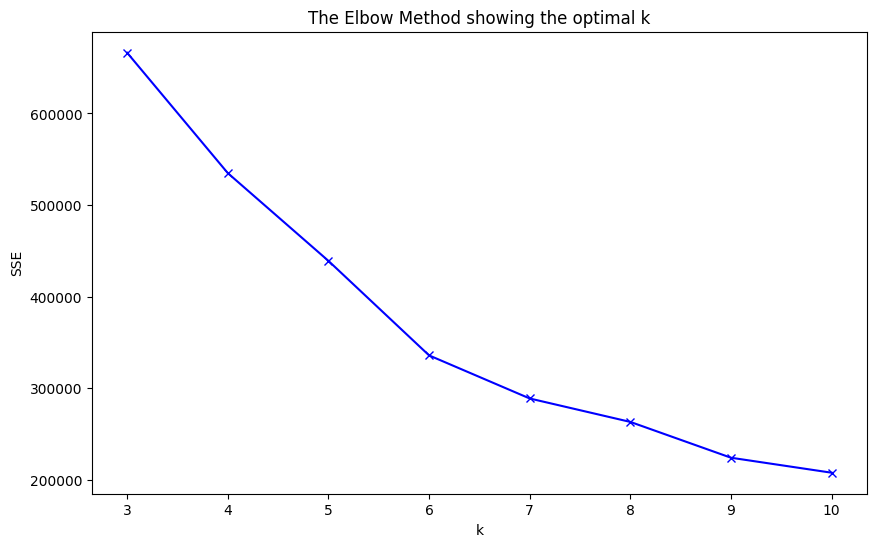

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(3, 11), sse_values, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method showing the optimal k')
plt.show()

#### **Silhoutte  score**

In [ ]:

silhouette_scores = []
for k in range(3, 11):  
    _, cluster_labels, _ = k_means(cluster_data, k)
    print('Model is done')
    score = silhouette_score(cluster_data, cluster_labels)
    print('silhouette_score is done')
    silhouette_scores.append(score)
    print(f"K={k}, Silhouette Score={score}")

Model is done
silhouette_score is done
K=2, Silhouette Score=0.6119500189495521
Model is done
silhouette_score is done
K=3, Silhouette Score=0.4070468370334128
Model is done
silhouette_score is done
K=4, Silhouette Score=0.44105637224284155
Model is done
silhouette_score is done
K=5, Silhouette Score=0.48572324817084034
Model is done
silhouette_score is done
K=6, Silhouette Score=0.5070577032893848
Model is done
silhouette_score is done
K=7, Silhouette Score=0.5140584128155535
Model is done
silhouette_score is done
K=8, Silhouette Score=0.5214243334906672
Model is done
silhouette_score is done
K=9, Silhouette Score=0.5127772853844371
Model is done
silhouette_score is done
K=10, Silhouette Score=0.48553289383088116


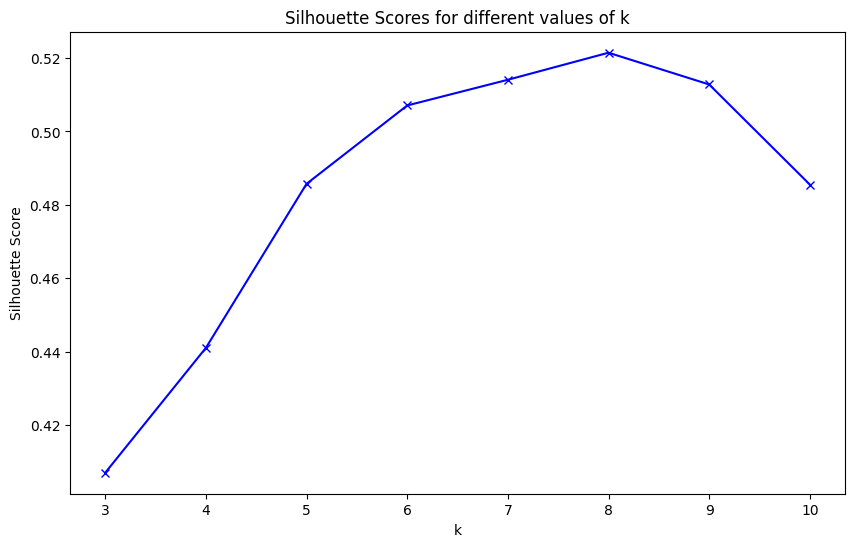

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(3, 11), silhouette_scores[1:], 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for different values of k')
plt.show()

Elbow Method is more subjective, as it requires you to identify the point at which the SSE curve starts to flatten out, which can sometimes be open to interpretation.

Silhouette Score provides a more objective measure of how well the data is clustered. The score is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation).

* In our case, the Elbow Method suggests 6 might be the optimal number of clusters, while the Silhouette Score suggests k=8.

* Given the Silhouette Score is more objective and the peak at k=8 is quite pronounced, so we will choose 8 cluster. The reason for this choice is that the silhouette score at k=8 is the highest among the values of k we've tested, indicating that the clusters are, on average, more distinct and appropriately spaced from each other than for other values of k. This often results in more practical and interpretable cluster assignments.



#### **K Means ++ implementation**

In [ ]:

def initialize_centroids_plusplus(data, k):
    n_samples, n_features = data.shape
    centroids = np.empty((k, n_features), dtype=data.dtype)
    centroids[0] = data[np.random.randint(n_samples)]
    
    for i in range(1, k):
        distances = np.min(np.sum((data[:, np.newaxis, :] - centroids[np.newaxis, :i, :]) ** 2, axis=2), axis=1)
        probabilities = distances / np.sum(distances)
        cumulative_probabilities = np.cumsum(probabilities)
        r = np.random.rand()
        centroid_index = np.searchsorted(cumulative_probabilities, r)
        centroids[i] = data[centroid_index]
    
    return centroids



def k_means_plusplus(data, k=3, max_iterations=100):
    centroids = initialize_centroids_plusplus(data, k)
    clusters = {}
    for _ in range(max_iterations):
        clusters = assign_clusters(data, centroids)
        new_centroids = update_centroids(clusters)
        
        if np.array_equal(centroids, new_centroids):
            break
        
        centroids = new_centroids

    cluster_labels = []
    for point in data:
        distances = np.linalg.norm(point - centroids, axis=1)
        closest_centroid = np.argmin(distances)
        cluster_labels.append(closest_centroid)

    # Calculate SSE
    sse = 0
    for centroid_index, points in clusters.items():
        for point in points:
            sse += np.linalg.norm(point - centroids[centroid_index]) ** 2
    
    return centroids, cluster_labels, sse


In [ ]:
sse_values = []
for k in range(3, 11):  # Test K from 1 to 10
    try:
        _, cluster_labels, sse = k_means_plusplus(cluster_data, k)
        sse_values.append(sse)
        print(f"K={k}, SSE={sse}")
    except Exception as e:
        print(f"An error occurred at K={k}: {e}")

K=3, SSE=800051.4894635245
K=4, SSE=567022.6106302186
K=5, SSE=502105.5396667685
K=6, SSE=378037.6202445253
K=7, SSE=288880.0480911013
K=8, SSE=273013.21331755986
K=9, SSE=224503.54639358353
K=10, SSE=201954.12528045557


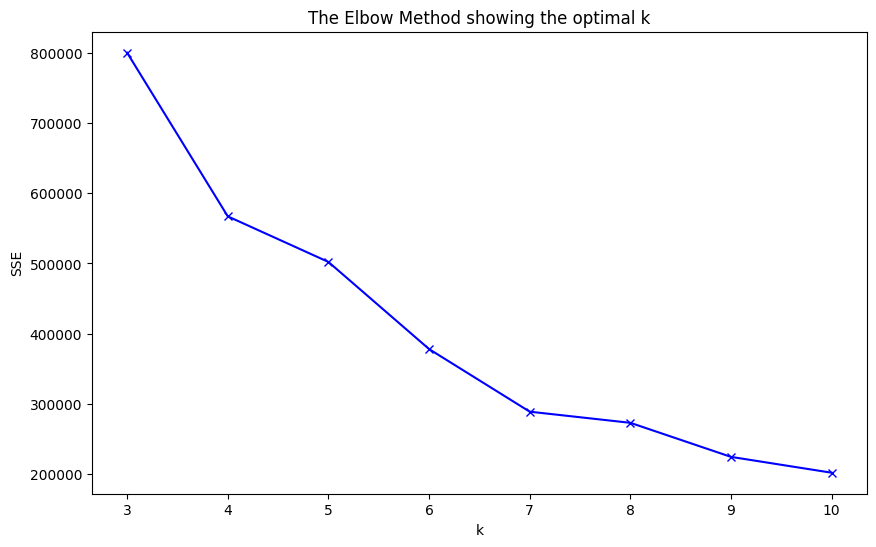

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(3, 11), sse_values, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
silhouette_scores = []
for k in range(3, 11):
    _, cluster_labels, _ = k_means_plusplus(cluster_data, k)
    print('Model is done')
    score = silhouette_score(cluster_data, cluster_labels)
    print('silhouette_score is done')
    silhouette_scores.append(score)
    print(f"K={k}, Silhouette Score={score}")

Model is done
silhouette_score is done
K=3, Silhouette Score=0.4070468370334128
Model is done
silhouette_score is done
K=4, Silhouette Score=0.44578144717237483
Model is done
silhouette_score is done
K=5, Silhouette Score=0.46513621564891994
Model is done
silhouette_score is done
K=6, Silhouette Score=0.3573023728689805
Model is done
silhouette_score is done
K=7, Silhouette Score=0.5129992569237043
Model is done
silhouette_score is done
K=8, Silhouette Score=0.5206182616321725
Model is done
silhouette_score is done
K=9, Silhouette Score=0.5213411989172012
Model is done
silhouette_score is done
K=10, Silhouette Score=0.32127553432839767


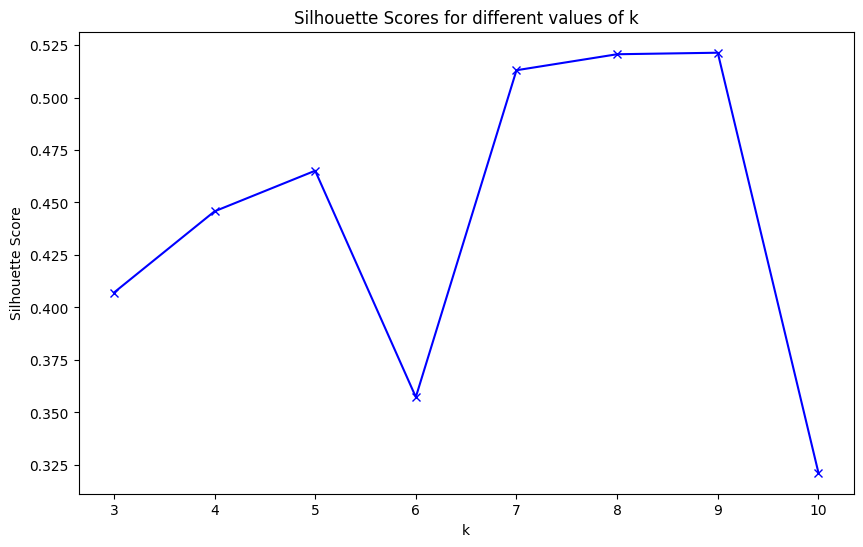

In [ ]:
# Plotting the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(3, 11), silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for different values of k')
plt.show()

* By looking at the elbow and sillhoutte score graphs, we can see that K-means++ leads to more reasoable clustering because the initial centroids are chosen to be far apart. We can see that variance between the different k-results are lesser than K-means results.
* For the convergence time, K-means ++ converge faster than K-means as expected.

#### **DBSCAN implementation**

In [ ]:

cluster_data = numeric_features_pca_df.values


# Apply DBSCAN clustering algorithm
# eps and min_samples are hyperparameters that can be tuned
# For this example, we'll use default values
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(cluster_data)

# Number of clusters found (excluding noise points)
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)

n_clusters, clusters[:10]  # Display the number of clusters and first 10 cluster assignments


(22, array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [ ]:
silhouette_score_dbscan = silhouette_score(cluster_data, clusters)
silhouette_score_dbscan

0.5308737740424372

* For DBSCAN, There is no need require the number of clusters to be specified. It determines the number of clusters based on the data.
* DBSCAN relies on two parameters: eps, the size of the neighborhood to consider, and min_samples, the minimum number of points required to form a dense region.
* To compare k-means implementation and DBSCAN, we also calculated silhoutte score for DBSCAN. It seems that both methods shows very similar performance according to sillohoutte score, but the best number of cluster for dbscan is 22. We decide to not increase the number of cluster in k-means because it take too much time.

### [2.4] Analysing your results!

In [ ]:
cluster_data = numeric_features_pca_df.values
_, cluster_labels, _ = k_means(cluster_data, k = 6)
all_features['cluster_number'] = cluster_labels
all_features

,user_id,favorite_genre,genre_count,average_click_duration,time_of_day,movie_age_category,average_daily_duration,total_clicks,unique_movie_count,title,total_time_spent,weekend_ratio,most_common_release_year,longest_single_viewing,total_genres_watched,last_movie_watched,first_movie_watched,clusters,cluster_number
0,1dea19f6fe,Comedy,1,0.000000,Night,Old,0.000000,1,1,"Angus, Thongs and Perfect Snogging",0.0,1.000000,2008-07-25,0.0,3,"Angus, Thongs and Perfect Snogging","Angus, Thongs and Perfect Snogging",0,0
1,544dcbc510,Romance,10,1553.750000,Night,Old,18645.000000,12,8,Twilight,18645.0,1.000000,2008-11-21,10933.0,8,The Twilight Saga: New Moon,The Curse of Sleeping Beauty,1,1
2,7cbcc791bf,Action,5,4218.666667,Night,Recent,8437.333333,6,4,London Has Fallen,25312.0,0.500000,2016-03-04,10530.0,9,Shrek 2,London Has Fallen,1,1
3,ebf43c36b6,Action,9,1883.533333,Afternoon,Recent,9417.666667,15,12,London Has Fallen,28253.0,0.733333,2015-06-12,7524.0,11,The Last Stand,Transporter 3,1,1
4,a57c992287,Drama,15,3684.538462,Night,Recent,7369.076923,26,22,The Firm,95798.0,0.192308,1993-06-30,56338.0,21,When Pigs Have Wings,A Dog's Life,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161913,45414be0ec,Comedy,1,0.000000,Night,Recent,0.000000,1,1,Always Be My Maybe,0.0,1.000000,2019-05-31,0.0,2,Always Be My Maybe,Always Be My Maybe,0,0
161914,783ec67e84,Sport,1,0.000000,Night,Old,0.000000,1,1,The Blind Side,0.0,1.000000,2009-11-20,0.0,3,The Blind Side,The Blind Side,0,0
161915,89c715f3a4,Comedy,1,-1.000000,Night,Recent,-1.000000,1,1,Despicable Me 3,-1.0,1.000000,2017-06-30,-1.0,6,Despicable Me 3,Despicable Me 3,0,0
161916,9207e1499b,Biography,1,42592.000000,Night,Recent,42592.000000,1,1,The Wolf of Wall Street,42592.0,1.000000,2013-12-25,42592.0,3,The Wolf of Wall Street,The Wolf of Wall Street,0,0


In [ ]:
all_features['average_click_duration_cat'] = pd.qcut(all_features['average_click_duration'], 4, labels=False)
all_features['average_daily_duration_cat'] = pd.qcut(all_features['average_daily_duration'], 4, labels=False)
all_features

,user_id,favorite_genre,genre_count,average_click_duration,time_of_day,movie_age_category,average_daily_duration,total_clicks,unique_movie_count,title,...,weekend_ratio,most_common_release_year,longest_single_viewing,total_genres_watched,last_movie_watched,first_movie_watched,clusters,cluster_number,average_click_duration_cat,average_daily_duration_cat
0,1dea19f6fe,Comedy,1,0.000000,Night,Old,0.000000,1,1,"Angus, Thongs and Perfect Snogging",...,1.000000,2008-07-25,0.0,3,"Angus, Thongs and Perfect Snogging","Angus, Thongs and Perfect Snogging",0,0,0,0
1,544dcbc510,Romance,10,1553.750000,Night,Old,18645.000000,12,8,Twilight,...,1.000000,2008-11-21,10933.0,8,The Twilight Saga: New Moon,The Curse of Sleeping Beauty,1,1,1,2
2,7cbcc791bf,Action,5,4218.666667,Night,Recent,8437.333333,6,4,London Has Fallen,...,0.500000,2016-03-04,10530.0,9,Shrek 2,London Has Fallen,1,1,2,2
3,ebf43c36b6,Action,9,1883.533333,Afternoon,Recent,9417.666667,15,12,London Has Fallen,...,0.733333,2015-06-12,7524.0,11,The Last Stand,Transporter 3,1,1,1,2
4,a57c992287,Drama,15,3684.538462,Night,Recent,7369.076923,26,22,The Firm,...,0.192308,1993-06-30,56338.0,21,When Pigs Have Wings,A Dog's Life,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161913,45414be0ec,Comedy,1,0.000000,Night,Recent,0.000000,1,1,Always Be My Maybe,...,1.000000,2019-05-31,0.0,2,Always Be My Maybe,Always Be My Maybe,0,0,0,0
161914,783ec67e84,Sport,1,0.000000,Night,Old,0.000000,1,1,The Blind Side,...,1.000000,2009-11-20,0.0,3,The Blind Side,The Blind Side,0,0,0,0
161915,89c715f3a4,Comedy,1,-1.000000,Night,Recent,-1.000000,1,1,Despicable Me 3,...,1.000000,2017-06-30,-1.0,6,Despicable Me 3,Despicable Me 3,0,0,0,0
161916,9207e1499b,Biography,1,42592.000000,Night,Recent,42592.000000,1,1,The Wolf of Wall Street,...,1.000000,2013-12-25,42592.0,3,The Wolf of Wall Street,The Wolf of Wall Street,0,0,3,3


#### Variable 1: [2.4.1] Time of the Day

In [ ]:
pivot_time_of_day = pd.pivot_table(all_features, values='user_id', index='clusters', columns='time_of_day', aggfunc='count', fill_value=0)
pivot_time_of_day_percentage = pivot_time_of_day.div(pivot_time_of_day.sum(axis=1), axis=0) * 100
pivot_time_of_day_percentage

time_of_day,Afternoon,Morning,Night
clusters,,,
0,29.316838,10.909533,59.773629
1,22.479000,9.453011,68.067989
2,14.805825,7.200647,77.993528
3,26.635014,10.608353,62.756633
4,23.611688,10.012464,66.375848
5,27.395577,11.425061,61.179361


* Cluster 0 and Cluster 1 similar to each othe based night watcher percentages.
* Cluster 2 has the highest percentage of night watchers (77.99%), indicating a strong preference for nighttime.
* Cluster 3,4 and 5  has more balanced distirbution and similar to each others also.

#### Variable 2: [2.4.2] avergae_click_duration_cat


In [ ]:
pivot_avg_click_duration = pd.pivot_table(
    all_features, 
    values='user_id', 
    index='clusters', 
    columns='average_click_duration_cat', 
    aggfunc='count', 
    fill_value=0
)
pivot_avg_click_duration_percentage = pivot_avg_click_duration.div(pivot_avg_click_duration.sum(axis=1), axis=0) * 100
pivot_avg_click_duration_percentage

average_click_duration_cat,0,1,2,3
clusters,,,,
0,39.934802,19.587754,22.434599,18.042844
1,1.246204,15.388256,47.754072,35.611468
2,0.000000,5.056634,64.037217,30.906149
3,41.901234,19.689302,20.487569,17.921895
4,0.000000,0.000000,0.000000,100.000000
5,0.000000,0.000000,0.000000,100.000000


* Cluster 0 has a more even distribution across quartiles.
* In cluster 1, users tend to have longer click durations.
* Cluster 2 has heavily skewed towards longer click durations.
* Cluster 3 is similar to cluster 0, balanced distirbution across quartiles.
* Cluster 4 and Cluster 5, all users have the longest click durations.

### Variable 3: [2.4.3] average_daily_duration_cat

In [ ]:
pivot_avg_daily_duration = pd.pivot_table(
    all_features, 
    values='user_id', 
    index='clusters', 
    columns='average_daily_duration_cat', 
    aggfunc='count', 
    fill_value=0
)

pivot_avg_daily_duration_percentage = pivot_avg_daily_duration.div(pivot_avg_daily_duration.sum(axis=1), axis=0) * 100
pivot_avg_daily_duration_percentage

average_daily_duration_cat,0,1,2,3
clusters,,,,
0,39.934802,20.470560,22.685673,16.908966
1,1.246204,12.580353,46.657728,39.515716
2,0.000000,2.063107,50.364078,47.572816
3,41.901234,20.145827,21.129314,16.823625
4,0.000000,0.000000,0.000000,100.000000
5,0.000000,0.000000,0.000000,100.000000


* Cluster 0 has the highest percentage for shorter daily viewing durations across the all clusters.
* Most of the Cluster 1  and Cluster 2 Users are in the higher durations quartiles.
* Cluster 3 as a relatively even distribution.
* Cluster 4 and 5 are has highest daily viewing durations

#### Summary
* Clusters 0 and 3 show a more balanced distribution of viewing across different times of the day and duration quartiles.
* Cluster 1 and 2 show a tendency towards longer durations, especially in evening.
* Clusters 4 and 5 are characterized by the longest engagement in terms of click and daily viewing durations, indicative of highly engaged users.


#### Silhouette scores for clusters.

In [ ]:

file_path_numeric_features_pca = '/mnt/data/numeric_features_pca.csv'

numeric_features_pca_df['user_id'] = all_features['user_id']


numeric_features_pca_with_clusters_df = numeric_features_pca_df.merge(all_features[['user_id', 'clusters']], on='user_id')

# Extract the features and cluster labels
X = numeric_features_pca_with_clusters_df.drop(['user_id', 'clusters'], axis=1).values
cluster_labels = numeric_features_pca_with_clusters_df['clusters'].values

silhouette_avg = silhouette_score(X, cluster_labels)

silhouette_avg


0.5070577032893848

* This is a moderate score for cluster seperation. With a score of around 0.50, the clusters defined in the dataset have areas of overlap but are reasonably distinct from each other.

# [3] Bonus Question
---

I asked chatGPT which are the three algorithms for Density-Based Clustering, it suggested to me:

- **DBSCAN** (Density-Based Spatial Clustering of Applications with Noise): DBSCAN is a density-based clustering non-parametric algorithm. It groups together points that are closely packed together (points with many nearby neighbors), marking as outliers points that lie alone in low-density regions1.

- **OPTICS** (Ordering Points To Identify the Clustering Structure): OPTICS is an algorithm for finding density-based clusters in spatial data. It’s similar to DBSCAN, but it addresses one of DBSCAN’s major weaknesses: the problem of detecting meaningful clusters in data of varying density2.

- **Mean Shift Clustering**: Mean shift is a non-parametric feature-space analysis technique for locating the maxima of a density function, a so-called mode-seeking algorithm. It is particularly useful for datasets where the clusters have arbitrary shapes and are not well-separated by linear boundaries3.

We started considering **DBSCAN** as the optimal choice because it doesn't require specifying the number of clusters in the data first
. It can identify clusters, even those completely surrounded by (but not connected to) a different cluster. The required parameters can be set by a domain expert if the data is well-understood. Given a set of points in some space, DBSCAN groups together points that are closely packed (points with many nearby neighbors) and marks as outliers those points that lie alone in low-density regions.

On the other hand, **OPTICS** is similar to **DBSCAN** but addresses the challenge of detecting meaningful clusters in data with varying density. To achieve this, the points of the database are linearly ordered, so spatially closest points become neighbors in the ordering. Additionally, a special distance is stored for each point, representing the density necessary for two points to belong to the same cluster. This information is then represented as a dendrogram.

Therefore, we believe that the second algorithm can better explain and represent our data.

In [ ]:
import pandas as pd
df = pd.read_csv('vodclickstream_uk_movies_03.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671736 entries, 0 to 671735
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    671736 non-null  int64  
 1   datetime      671736 non-null  object 
 2   duration      671736 non-null  float64
 3   title         671736 non-null  object 
 4   genres        671736 non-null  object 
 5   release_date  671736 non-null  object 
 6   movie_id      671736 non-null  object 
 7   user_id       671736 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 41.0+ MB


We decide to use sklearn library that consider that OPTICS is related to DBSCAN so this algorithm keeps cluster hierarchy for a variable neighborhood radius. Clusters are then extracted using a DBSCAN-like method (cluster_method = ‘dbscan’) or an automatic technique(cluster_method = ‘xi’).

This implementation deviates from the original OPTICS by first performing k-nearest-neighborhood searches on all points to identify core sizes, then computing only the distances to unprocessed points when constructing the cluster order. Note that we do not employ a heap to manage the expansion candidates, so the time complexity will be O(n^2).

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.cluster import DBSCAN

In [ ]:
df = pd.read_csv('numeric_features_pca.csv')

c:\Users\rebbi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:995: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


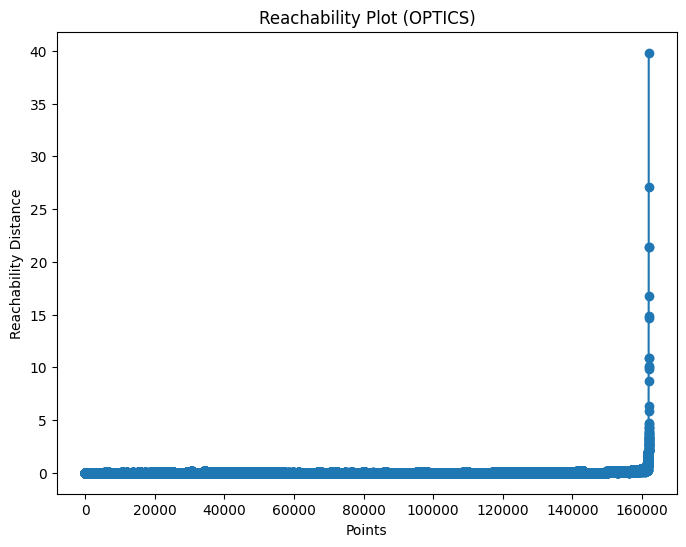

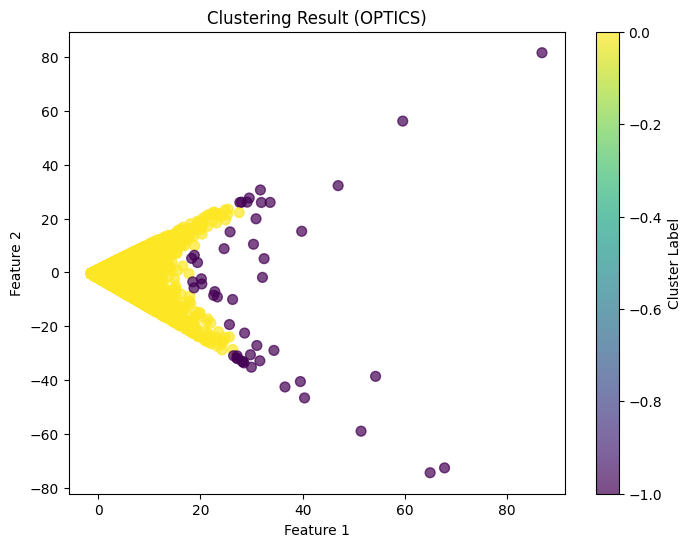

In [ ]:
from sklearn.cluster import OPTICS
import matplotlib.pyplot as plt

# Creating the OPTICS model and fitting it to our data
optics = OPTICS(min_samples=5, xi=0.05, min_cluster_size=0.1)
optics.fit(df)

# Plotting the reachability plot
plt.figure(figsize=(8, 6))
reachability = optics.reachability_[optics.ordering_]
plt.plot(reachability, marker='o')
plt.title('Reachability Plot (OPTICS)')
plt.xlabel('Points') 
plt.ylabel('Reachability Distance')
plt.show()

# Plotting the cluster plot
plt.figure(figsize=(8, 6))
plt.scatter(df['PC1'], df['PC2'], c=optics.labels_, cmap='viridis', s=50, alpha=0.7)
plt.title('Clustering Result (OPTICS)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

Y-axis rappresent the reachability distance of a point, the distance at which it could be included in another point’s cluster. It’s essentially a measure of how far we have to reach to include a point in a cluster. Points with a lower reachability distance are more similar to their neighbors.In our case most of our points have a lower reachability.
In general in the reachability plot typically there are valley that corresponds to a cluster. The depth of the valley indicates the density of the cluster: deeper valleys correspond to denser clusters. Points that are not part of any valley are considered noise. In our case we don't have valley, but onlya a long line that we consider as noise so it is impossible to analyse this result


For this reason we decide to use another dataset created using the mca method that consider also the categorical data.
We start from the dataset that contain also the new features created at the start of the second point and from this we create the mca dataframe. We use only 10000 sample because it take too long time to run

In [ ]:
import pandas as pd
import prince

df = all_features_scaled_df

# Crea un oggetto MCA
mca = prince.MCA()

# Supponiamo che tu voglia elaborare i tuoi dati in lotti di dimensione 'batch_size'
batch_size = 10000  
num_batches = len(df) // batch_size

for i in range(num_batches):
    # Seleziona il lotto corrente di dati
    batch_data = df[i*batch_size : (i+1)*batch_size]

    # Adatta l'oggetto MCA al lotto corrente
    mca = mca.fit(batch_data)

    # Applica la trasformazione dell'analisi delle corrispondenze multiple
    df_transformed = mca.transform(batch_data)

    # Ora 'df_transformed' contiene le caratteristiche continue derivanti del lotto corrente
    # Puoi usare queste caratteristiche per fare il clustering che preferisci


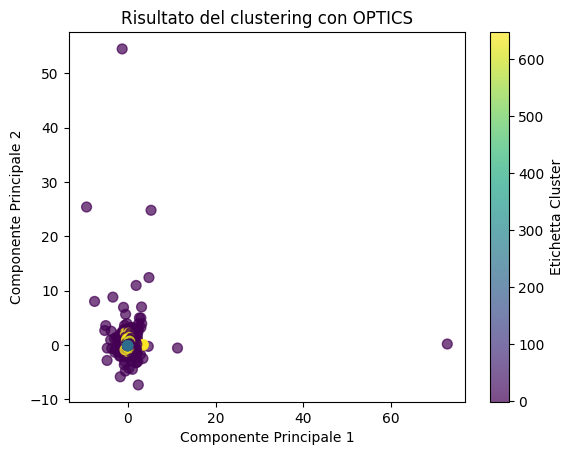

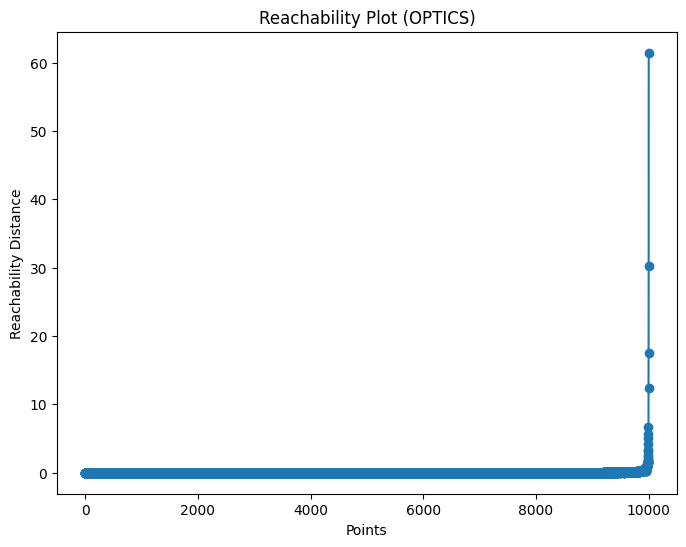

In [ ]:

from sklearn.cluster import OPTICS
import matplotlib.pyplot as plt

min_samples = 5
xi = 0.05

# Crea un oggetto OPTICS e adattalo ai tuoi dati
optics = OPTICS(min_samples=min_samples, xi=xi)
clusters = optics.fit_predict(df_transformed)

# Visualizza i risultati del clustering in un grafico a dispersione
plt.scatter(df_transformed.iloc[:, 0], df_transformed.iloc[:, 1], c=clusters, cmap='viridis', s=50, alpha=0.7)
plt.title('Risultato del clustering con OPTICS')
plt.xlabel('Componente Principale 1')
plt.ylabel('Componente Principale 2')
plt.colorbar(label='Etichetta Cluster')
plt.show()

plt.figure(figsize=(8, 6))
reachability = optics.reachability_[optics.ordering_]
plt.plot(reachability, marker='o')
plt.title('Reachability Plot (OPTICS)')
plt.xlabel('Points') 
plt.ylabel('Reachability Distance')
plt.show()



The result are not at all better reguarding the reachability but from the plot of the cluster we can recognize more value. i think that with more time we can create two different dataframe one for categorical value and one for the others and analyze them separately.

# [4] Command Line Question
---

In this question, we used command line tools on Linux operating system to answer the following questions using the same dataset that we have been using so far:

* What is the most-watched Netflix title?
* Report the average time between subsequent clicks on Netflix.com
* Provide the ID of the user that has spent the most time on Netflix

**LOOK THE CODE IN THE SCRIPT FILE COMMANDLINE.SH**

**Output**

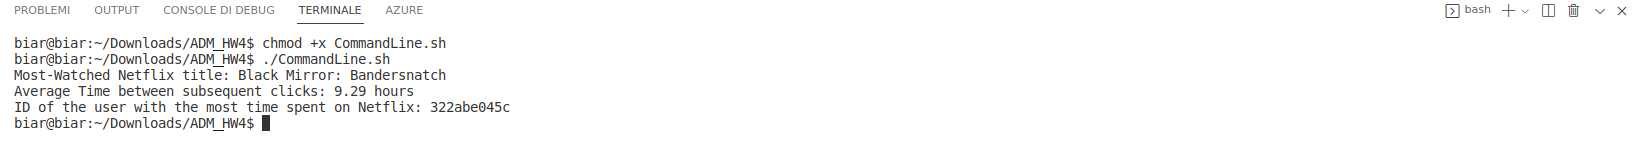

## [4] Algorithmic Question
---

Federico studies in a demanding university where he has to take a certain number $N$ of exams to graduate, but he is free to choose in which order he will take these exams. Federico is panicking since this university is not only one of the toughest in the world but also one of the weirdest. His final grade won't depend at all on the mark he gets in these courses: there's a precise evaluation system.

He was given an initial personal score of $S$ when he enrolled, which changes every time he takes an exam: now comes the crazy part. He soon discovered that every of the $N$ exams he has to take is assigned a mark $p$. Once he has chosen an exam, his score becomes equal to the mark $p$, and at the same time, the scoring system changes:

If he takes an "easy" exam (the score of the exam being less than his score), every other exam's mark is increased by the quantity $S-p$.
If he takes a "hard" exam (the score of the exam is greater than his score), every other exam's mark is decreased by the quantity $p-S$.

In this chaotic university where the only real exam seems to be choosing the best way to take exams, you are the poor student advisor who is facing a long queue of confused people who need some help. Federico is next in line, and he comes up in turn with an inescapable question: he wants to know which is the highest score possible he could get.

**a) Fortunately, you have a computer app designed by a brilliant student. Federico wants you to show him the code which this app is based on because he wants to do paid counseling for other desperate students: in a recursive fashion, the helped helps the helpable.**

To find the highest score that can be achieved in this particular university, we have decided to create a recursive algorithm that performs the necessary operations to update the score at each iteration and then repeats them until it finds the maximum.

In [ ]:
def highest_possible_score(score, marks):
    if not marks:  # If there are no exams left to take, return the current score
        return score

    max_score = 0  # Initialize max_score

    for i, exam_score in enumerate(marks):
        new_marks = marks[:i] + marks[i + 1:]  # Exclude the current exam score
        new_score = exam_score  # Federico's score after taking the exam

        # Determine the change in marks based on the exam difficulty
        if exam_score < score:  # If it's an "easy" exam
            new_marks = [mark + (score - exam_score) if mark + (score - exam_score)>=0 else 0 for mark in new_marks]
        elif exam_score > score:  # If it's a "hard" exam
            new_marks = [mark - (exam_score - score) if mark - (exam_score - score)>=0 else 0 for mark in new_marks]

        # Recursively calculate the highest possible score after taking this exam
        max_score = max(max_score, highest_possible_score(new_score, new_marks))

    return max_score

# Test cases
s1 = 8
p1 = [5, 7, 1]
result1 = highest_possible_score(s1, p1)
print("Output 1:", result1)

s2 = 25
p2 = [18, 24, 21, 32, 27]
result2 = highest_possible_score(s2, p2)
print("Output 2:", result2)

s3 = 30
p3 = [13, 27, 41, 59, 28, 33, 39, 19, 52, 48, 55, 79]
result3 = highest_possible_score(s3, p3)
print("Output 3:", result3)


Output 1: 11
Output 2: 44
Output 3: 109


### Computational complexity

**b) Federico is getting angry because he claims that your code is slow! Show him formally with a big-O notation that he is as crazy as this university!**

The complexity of my algorithm is $O(n! \cdot n^2)$.

The number of recursive calls equals the number of permutations of possible exams, which is n!, where n is the number of exams.
Each recursive call executes a for loop over all the remaining exams.
Within the loop, operations involve copying the list of exams (O(n)), comparisons (O(1)), and addition or subtraction operations on the elements of the list (O(n)).

Therefore:

- O(n!) arises from the number of permutations of possible exams.
- $O(n^2)$ arises from the operations within each recursive call.

Indeed, as n grows larger, the execution time increases. In the case of the third example where p has a length of 12, the algorithm takes approximately 8 minutes to run. When considering comparing all the exams in a study program, it might take far too long, especially considering that a three-year study program has around 25 exams.


### Optimization

**c) If, unfortunately, Federico is right in the grip of madness, he will threaten you to optimize the code through a different approach. You should end this theater of the absurd by any means! (And again, formally prove that you improved time complexity)**

I tried to optimize it by creating a tuple to store each unique combination of score and marks, to avoiding redundant operations and with memoization, the number of unique subproblems calculated reduces significantly.

In [ ]:
def highest_possible_score(score, marks, memo={}):
    if not marks:
        return score

    if (score, tuple(marks)) in memo:  # If result is already calculated, return it
        return memo[(score, tuple(marks))]

    max_score = 0

    for i, exam_score in enumerate(marks):
        new_marks = marks[:i] + marks[i + 1:]

        if exam_score < score:
            new_marks = [mark + (score - exam_score) if mark + (score - exam_score)>=0 else 0 for mark in new_marks]
        elif exam_score > score:
            new_marks = [mark - (exam_score - score) if mark - (exam_score - score)>=0 else 0 for mark in new_marks]

        new_score = exam_score
        new_max_score = highest_possible_score(new_score, new_marks, memo)
        max_score = max(max_score, new_max_score)

    memo[(score, tuple(marks))] = max_score  # Store the calculated result in the memo

    return max_score

s1 = 8
p1 = [5, 7, 1]
result1 = highest_possible_score(s1, p1)
print("Output 1:", result1)

s2 = 25
p2 = [18, 24, 21, 32, 27]
result2 = highest_possible_score(s2, p2)
print("Output 2:", result2)

s3 = 30
p3 = [13, 27, 41, 59, 28, 33, 39, 19, 52, 48, 55, 79]
result3 = highest_possible_score(s3, p3)
print("Output 3:", result3)

Output 1: 11
Output 2: 44
Output 3: 109


The memoization effectively limits the number of unique subproblems to be solved to a maximum of the number of possible distinct combinations of score and marks.
The recursion in the worst case, for each exam, will consider two possibilities (easy or hard). So, if there are n exams, it would explore $2^n$ possibilities.

Considering these points, the time complexity of the memoized highest_possible_score function can be seen as improved from the naive exponential time complexity to something closer to $O(n \cdot s)$, where n is the number of exams and s is the range of possible score differences between exams.

It is evidently faster, in fact it take only 0.4 second to run.

### Chat GPT optimized implementation

**d) Ask chatGPT for a third (optimized) implementation and analyze again its time complexity. Be careful (and crafty) in defining the prompt, and challenge the machine in this coding question!**

I send to chat Gpt my last code and i ask it to optimize my code trying to reduce the computational complexity.  this is it output: 

In this code, I added a memo parameter to the highest_possible_score function that is used to store intermediate results. This memo dictionary is passed to each recursive call of the function, thus allowing it to store the results of each sub-problem. When the function is called with the same score and marks parameters, it simply returns the stored result instead of calculating it again.

In [ ]:
def highest_possible_score(score, marks, memo=None):
    if memo is None:
        memo = {}

    if not marks:
        return score

    if (score, tuple(marks)) in memo:  # If result is already calculated, return it
        return memo[(score, tuple(marks))]

    max_score = 0

    for i, exam_score in enumerate(marks):
        new_marks = marks[:i] + marks[i + 1:]

        if exam_score < score:
            new_marks = [mark + (score - exam_score)  if mark + (score - exam_score)>=0 else 0  for mark in new_marks]
        elif exam_score > score:
            new_marks = [mark - (exam_score - score) if mark - (exam_score - score)>=0 else 0 for mark in new_marks]

        new_score = exam_score
        new_max_score = highest_possible_score(new_score, new_marks, memo)
        max_score = max(max_score, new_max_score)

    memo[(score, tuple(marks))] = max_score  # Store the calculated result in the memo

    return max_score

s1 = 8
p1 = [5, 7, 1]
result1 = highest_possible_score(s1, p1)
print("Output 1:", result1)

s2 = 25
p2 = [18, 24, 21, 32, 27]
result2 = highest_possible_score(s2, p2)
print("Output 2:", result2)

s3 = 30
p3 = [13, 27, 41, 59, 28, 33, 39, 19, 52, 48, 55, 79]
result3 = highest_possible_score(s3, p3)
print("Output 3:", result3)


Output 1: 11
Output 2: 44
Output 3: 109


This version of the function is better in terms of optimization. The reason is that it initializes the memo dictionary inside the function. This means that a new memo dictionary is created every time the function is called, which prevents the dictionary from growing indefinitely and using up all the available memory.

In the first version of the function, the memo dictionary is initialized in the function’s parameter list. This means that the same memo dictionary is used for all calls to the function, even across different top-level calls. This can cause the dictionary to grow very large if the function is called many times, which can lead to high memory usage.

So, in terms of memory optimization, the second version of the function is better. However, in terms of time complexity, both versions of the function have the same time complexity of $O(n^2 \cdot m)$, where n is the number of elements in the marks list and m is the maximum value in the marks list. This is because the core logic of the function is the same in both versions.

